In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston, fetch_olivetti_faces
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Dimensionality reduction

## Objectives

* Describe dimensionality reduction
* List reasons why we would perform it
* Describe three or four DR strategies
* Define an orthonormal basis
* Describe the PCA procedure, in open- and closed-form
* Bonus: Define eigenvectors, eigenvalues
* Say what PCA is bad at

## Introduction

Datasets can have high dimensionality.

**Question to the class**: name some high-dimensional datasets; what are their dimensions?

### Challenges of high-dimensional data

* The **Curse of Dimensionality**
  * Distances in high-dimensional space can have little meaning in some cases.
  * It's can be infeasible to gather enough data to observe every feature interaction.
* Difficult to visualize
  * We can only make and understand 2- or 3-dimensional pictures.
* Redundant
  * Often a large number of features are transformations of a few meaningful latent features.
* Space-expensive
  * Huge numbers of features take up lots of disk space.
  
To address these challenges, we might be interested in a body of techniques that **reduce dimensionality**.

Thus there are three main reasons we might want to reduce dimensionality:
1. Compress data
2. Improve model performance
  * Actually less common than you'd think
3. Explore data
  * Most common use of dimensionality reduction

### Dimensionality Reduction techniques

* Forward Stepwise Selection
  * Just throw some features out by hand.
* LASSO regression
  * Use L1 feature regularization to throw features out.
* Neural Networks
  * Store the hidden layer neuron activations for a sample.
* Linear algebra tricks
  * **Principle Component Analysis** (PCA) - this morning
  * **Singular Value Decomposition** (SVD) - this afternoon
  * **Non-negative Matrix Factorization** (NMF) - tomorrow

## Introduction to Principle Component Analysis

PCA is a technique for using linear mappings to re-express a set of features in a form which has more meaningful. A simple example.

The finishing times for `A`, `B`, and `C` in the 100 and 200 meter dash

In [2]:
X = np.array([[14, 28], [15, 30], [20, 40]])
pd.DataFrame(X, index=["A", "B", "C"], columns=["100-meter dash", "200-meter dash"])

,100-meter dash,200-meter dash
A,14,28
B,15,30
C,20,40


You might an intuition that the features are redundant.
* The `200-meter dash` is 2*`200 meter dash`; the rank of the matrix is 1.

In [3]:
np.linalg.matrix_rank(X)

1

* Each feature is an expression of the latent feature `speed`.

In [4]:
speed = 100/X[:,0]
speed

array([7.14285714, 6.66666667, 5.        ])

Point being, we know that the data X can be expressed as a 1-dimensional (ie, one feature) matrix without loss of information.

Here's how PCA accomplishes this task:

First, notice that there is a **vector** that intersects all the data:

In [5]:
pca0 = X[0]/np.linalg.norm(X[0])
pca0

array([0.4472136 , 0.89442719])

This vector, along with a perpindicular vector, forms an orthogonal basis:

In [6]:
pca1 = np.cross(pca0, [0, 0, 1])[0:2]

In [7]:
basis_pca = np.stack([pca0, pca1]).T
basis_pca

array([[ 0.4472136 ,  0.89442719],
       [ 0.89442719, -0.4472136 ]])

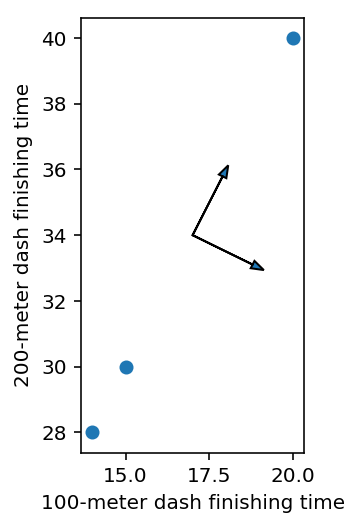

In [8]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.scatter( *X.T )
ax.set_xlabel("100-meter dash finishing time")
ax.set_ylabel("200-meter dash finishing time")

ax.arrow(17,17*2, pca0[0]*2, pca0[1]*2, head_width=0.25)
ax.arrow(17,17*2, pca1[0]*2, pca1[1]*2, head_width=0.25)

The projection of all data onto the first component - the line through the data - can be achived simply with a dot product.

In [9]:
X.dot( pca0 )

array([31.30495168, 33.54101966, 44.72135955])

We can also get the projection of the data onto the second principle component

In [10]:
X.dot( pca1 )

array([0., 0., 0.])

It would be much simpler to perform a matrix multiplication:

In [11]:
X_pca = X @ basis_pca
X_pca

array([[31.30495168,  0.        ],
       [33.54101966,  0.        ],
       [44.72135955,  0.        ]])

Thus every sample in $X$ has been converted to a sample in $X_{pca}$ by way of a linear mapping `basis_pca`.

Because `basis_pca` is both orthogonal (i.e., the dot product of any two columns is 0) and normal (i.e., the norm of any column is 1) "orthnormal", the projection of $X$ onto `basis_pca` can be conceptualized as a "rotation" - both the magnitudes and respective angles of all points are preserved.

Text(0, 0.5, 'second principle component')

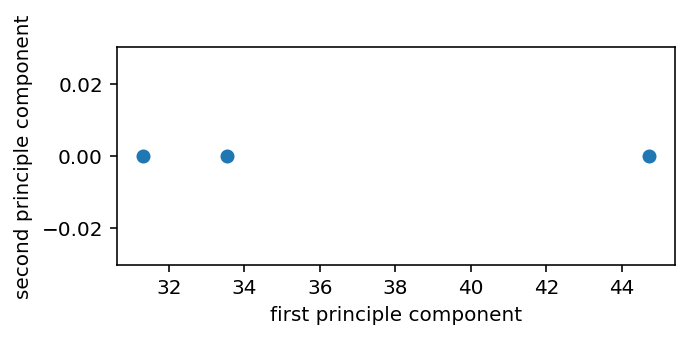

In [12]:
fig, ax = plt.subplots(figsize=(5,2))
ax.scatter( *X_pca.T )
ax.set_xlabel("first principle component")
ax.set_ylabel("second principle component")

Qualitatively: we've rotated the data into a coordinate space where a single dimension captures all of variation in the data.

These components don't have any meaning, but it's often easy to ascribe them some. In this case, the first principle component could be called the "slowness".

We could come up with some fictional samples with new slownesses:

In [13]:
slowness = [10, 36, 55, 40, 41.232]

And then convert them back into the original feature space with the inverse of `basis_pca` (which, because `basis_pca` is orthogonal, is equal to its transpose).

In [14]:
# times in the 100- and 200-meter dash
np.stack([slowness, np.zeros_like(slowness)]).T @ basis_pca.T

array([[ 4.47213595,  8.94427191],
       [16.09968944, 32.19937888],
       [24.59674775, 49.1934955 ],
       [17.88854382, 35.77708764],
       [18.43951097, 36.87902194]])

PCA boils down to this:
* Pick an orthonormal basis that you think represents your data well
* Rotate your data into that basis.

The question becomes - **how do we choose that basis**?

## Choosing a PCA basis

Given a sample set $X$ with shape (`n_samples`, `n_features`)

1. Pick a unit vector `pca_0` in $\mathbb{R}_n$ that maximizes the variance of $X$ projected onto `pca_0`.
2. Pick a unit vector `pca_1` orthogonal to `pca_0` that maximizes variance of $X$ projected onto `pca_1`.
3. Pick a unit vector `pca_2` orthogonal to previous vectors that maximize projected variance.
4. So on, until you have $n$ vectors forming an n-dimensional orthonormal basis.

### Why?

Using this scheme, often after the first few principle components, the variance of X projected along `pca_i` will be very small. This implies that the first componets faithfully capture most of the information about the samples.

In extreme cases, a very small number of principle components may completely describe the data. In this case, all we need to store the data is the the non-zero projected features, and the orthonormal basis.

**from our example** we only need to store the athlete "slowness" and the PCA basis; it tells us all we need to know.

### In practice

In [15]:
np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1, 0.6],[0.6,1]], size=300)

Text(0.5, 1.0, 'some fake data')

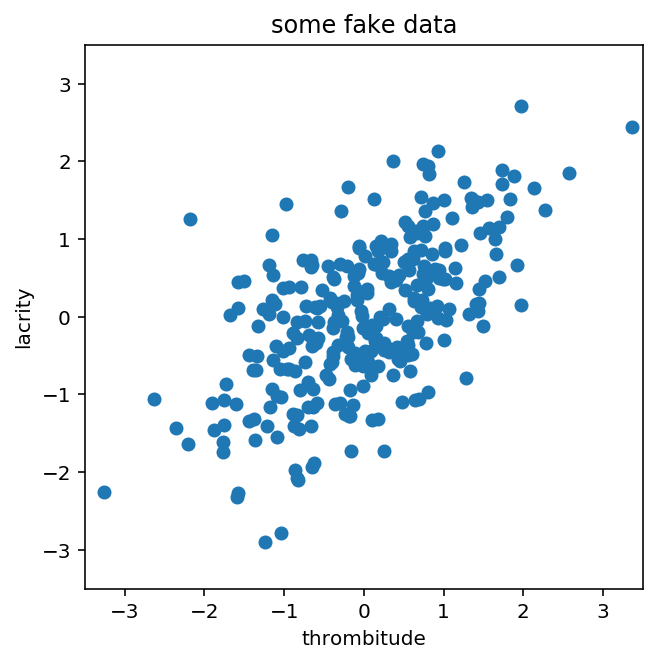

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(*X.T)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)
ax.set_xlabel("thrombitude")
ax.set_ylabel("lacrity")
ax.set_title("some fake data")

First I'll cook up unit vectors between 0 and 180 degrees:

In [17]:
angles = np.linspace(0, np.pi, 200)
pca0 = np.stack( [np.cos( angles ), np.sin( angles )] ) #each column is a potential PCA vector

Project onto every potential basis

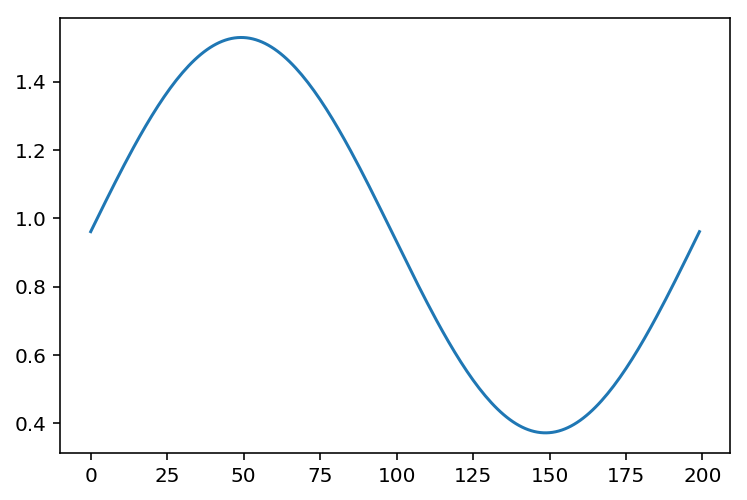

In [18]:
plt.plot( (X @ pca0).var(axis=0) )

Thus our best first principle component is

In [19]:
best_pca = (X @ pca0).std(axis=0).argmax()
best_pca

49

In [20]:
pca0.T[best_pca]

array([0.71542929, 0.69868515])

Which is about 45 degrees; about what you'd expect.

In [21]:
np.degrees( angles[best_pca] )

44.321608040201006

### A closed-form expression for ideal PCA basis

We don't actually have to search around for an ideal PCA basis - there exists a convenient closed-form expression.

**The ith pca vector is the ith eigenvector of the covariance matrix of $X$, and the variance of the ith component is the ith eigenvalue**.

In [22]:
variances, eigenvecs = np.linalg.eig( np.cov( X.T ) )

The first principle component is: 

In [23]:
#note, the `np.linalg.eig` func puts the ith eigenvector in the ith **column**
eigenvecs[:,0]

array([0.71334374, 0.70081432])

This is very close to the one we searched around for.

In [24]:
variances[0]

1.5344861567192178

This is the value of the peak of the crest in the above graph.

### Quick intermission: eigenvectors and eigenvalues

Any `m` by `n` matrix `A` can be considered a transformation operator on vectors of length `n`. Some matices scale, some rotate, some shear, or any combination of the above.

An eigenvector $v$ of matrix $A$ is a vector that, when operated upon by `A`, **does not change direction**. Both $A$ and $A v$ have the same norm. Often they are not the same length; the ratio of the two is called the "eigenvalue". This is often expressed:

$$Av = \lambda v$$

which I've never found helpful. I prefer the expression: **eigenvectors stay themselves when operated on by `A`**. Indeed, "eigen" is German for 'self".

## PCA in practice

`sklearn` provides a PCA transformer class.

In [25]:
#let's check out the boston data set

boston = load_boston()

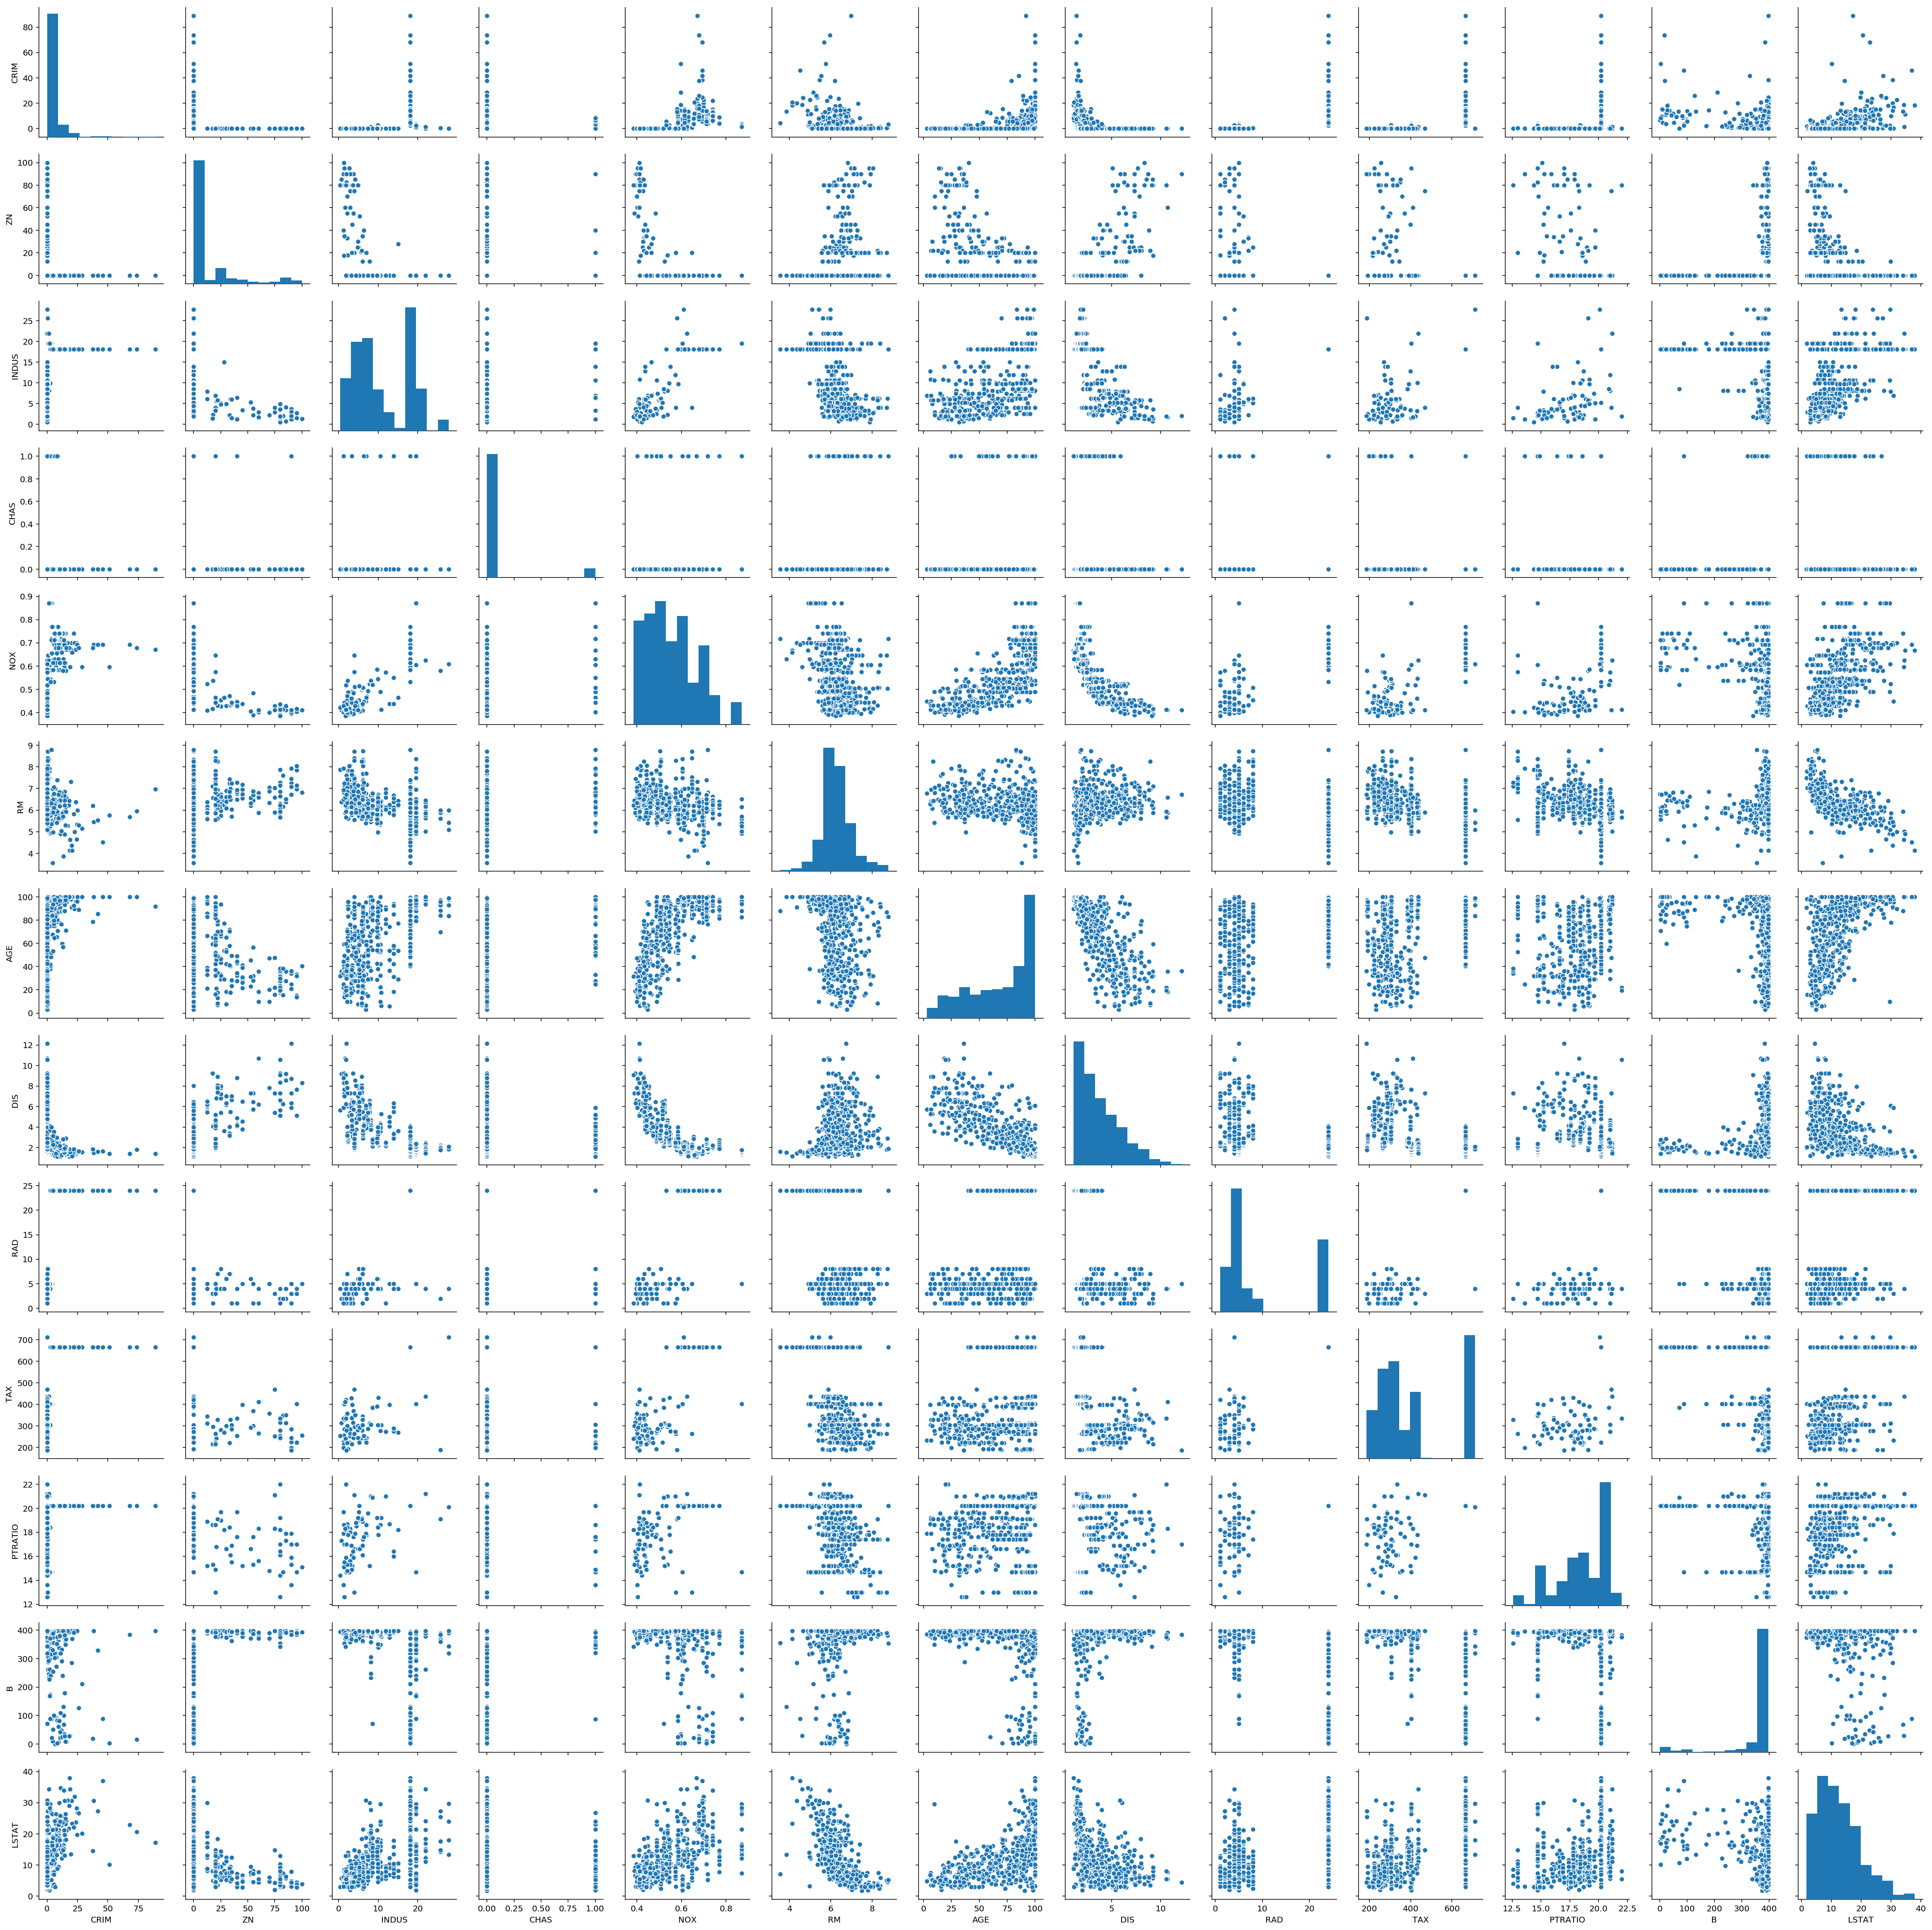

In [26]:
df = pd.DataFrame( boston.data, columns=boston.feature_names )
sns.pairplot(df)

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

It's important to standardize your features before performing PCA, or else the largest-scaled features dominate.

In [28]:
X = StandardScaler().fit_transform(df.values)

In [29]:
# create PCA transformer; fit

pca = PCA(n_components=len(df.columns))
pca.fit( X )

PCA(copy=True, iterated_power='auto', n_components=13, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'explanatory power of principle components')

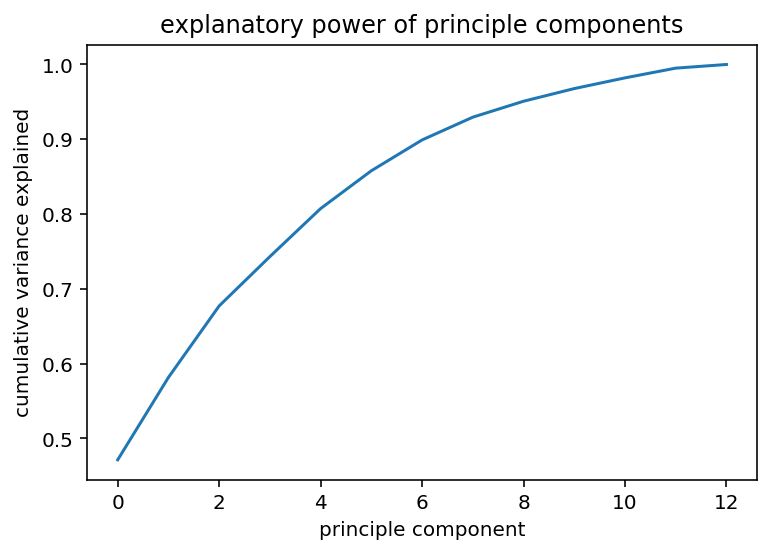

In [30]:
plt.plot( pca.explained_variance_.cumsum()/pca.explained_variance_.sum() )
plt.xlabel("principle component")
plt.ylabel("cumulative variance explained")
plt.title("explanatory power of principle components")

In [31]:
#transform Boston features; take first two PCA features
X_pca = pca.transform(X)[:,0:2]

Text(0.5, 1.0, 'boston housing data')

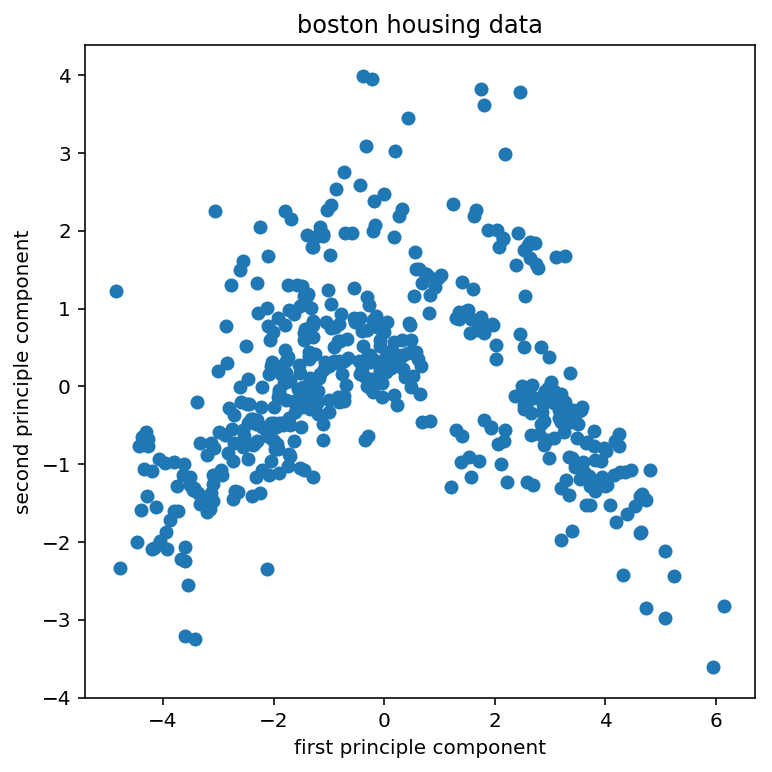

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter( *X_pca.T )
ax.set_xlabel("first principle component")
ax.set_ylabel("second principle component")
ax.set_title("boston housing data")

Let's try to explain the fist two principle components:

Text(0.5, 1.0, 'second component')

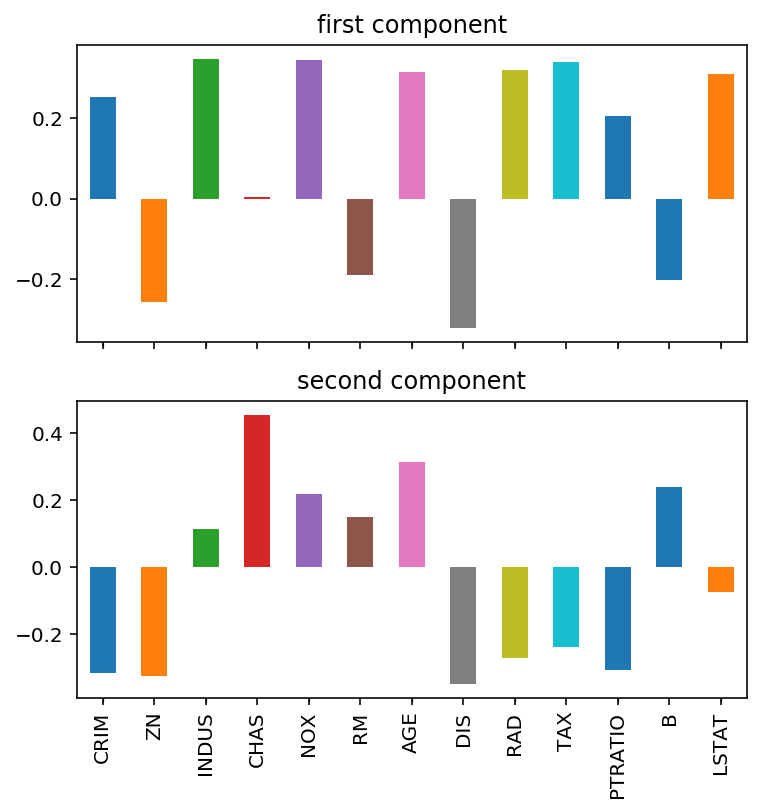

In [33]:
fig, axs = plt.subplots(2, sharex=True, figsize=(6,6))

pd.Series( pca.components_[0], boston.feature_names ).plot.bar(ax=axs[0])
axs[0].set_title("first component")
pd.Series( pca.components_[1], boston.feature_names ).plot.bar(ax=axs[1])
axs[1].set_title("second component")

* The first component is positively sensitive to measures of the presence of industry, we could call it "industrial".
* The second component is mostly sensitive to nearness to the Charles River and negatively sensitive to crime. We could call it "nice".
 
The most separated clump is in "not nice, industrial", which makes sense.

## Very high dimensional data: eigenfaces

In [34]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [35]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

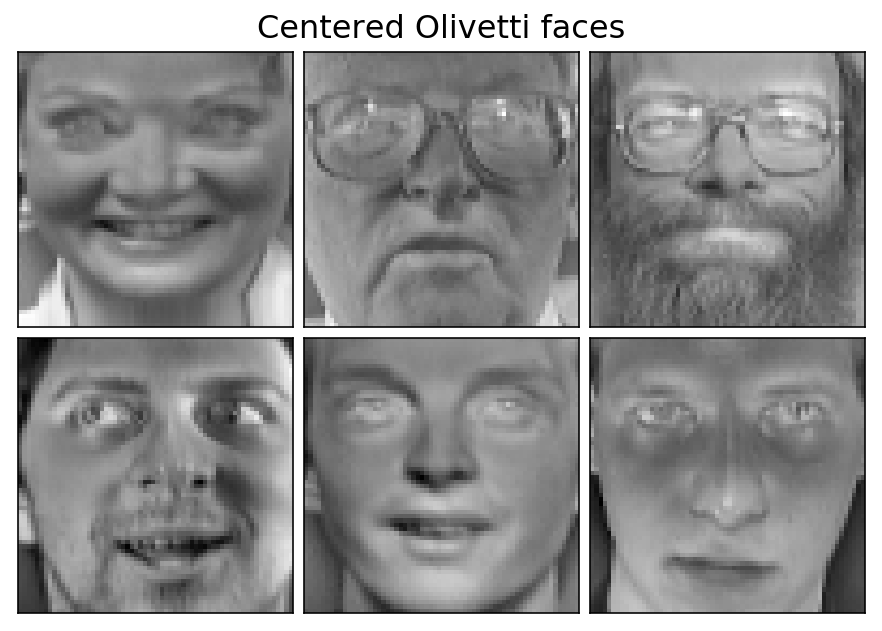

In [36]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Already kind of a nightmare. But we can do better!

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

In [37]:
faces_pcd = PCA(100).fit(faces_centered)

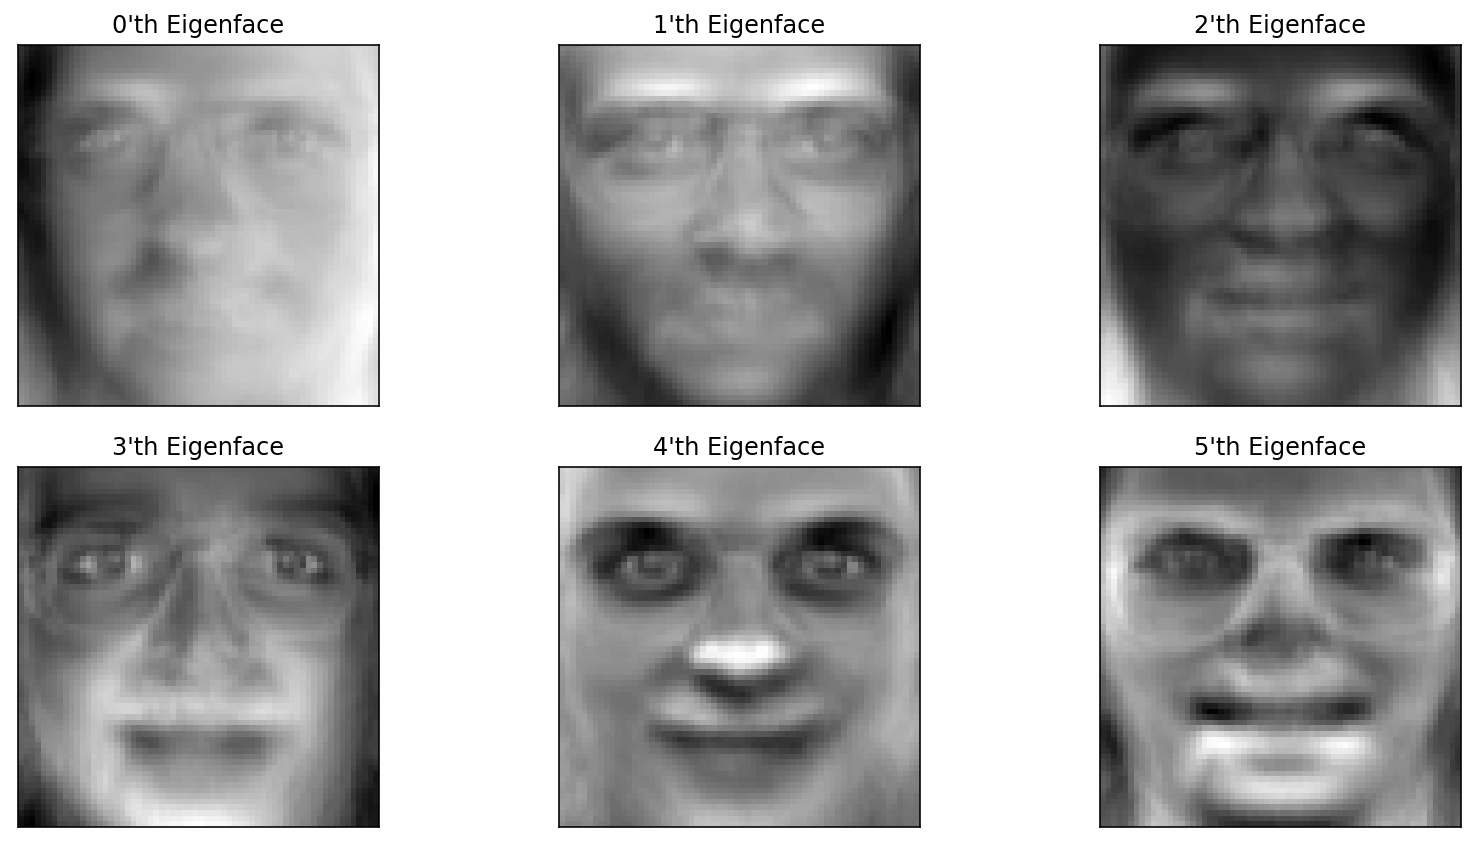

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap="gray")
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

In [39]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = np.dot(np.dot(faces_centered, eigenvalues), eigenvalues.T)
    return faces_reduced

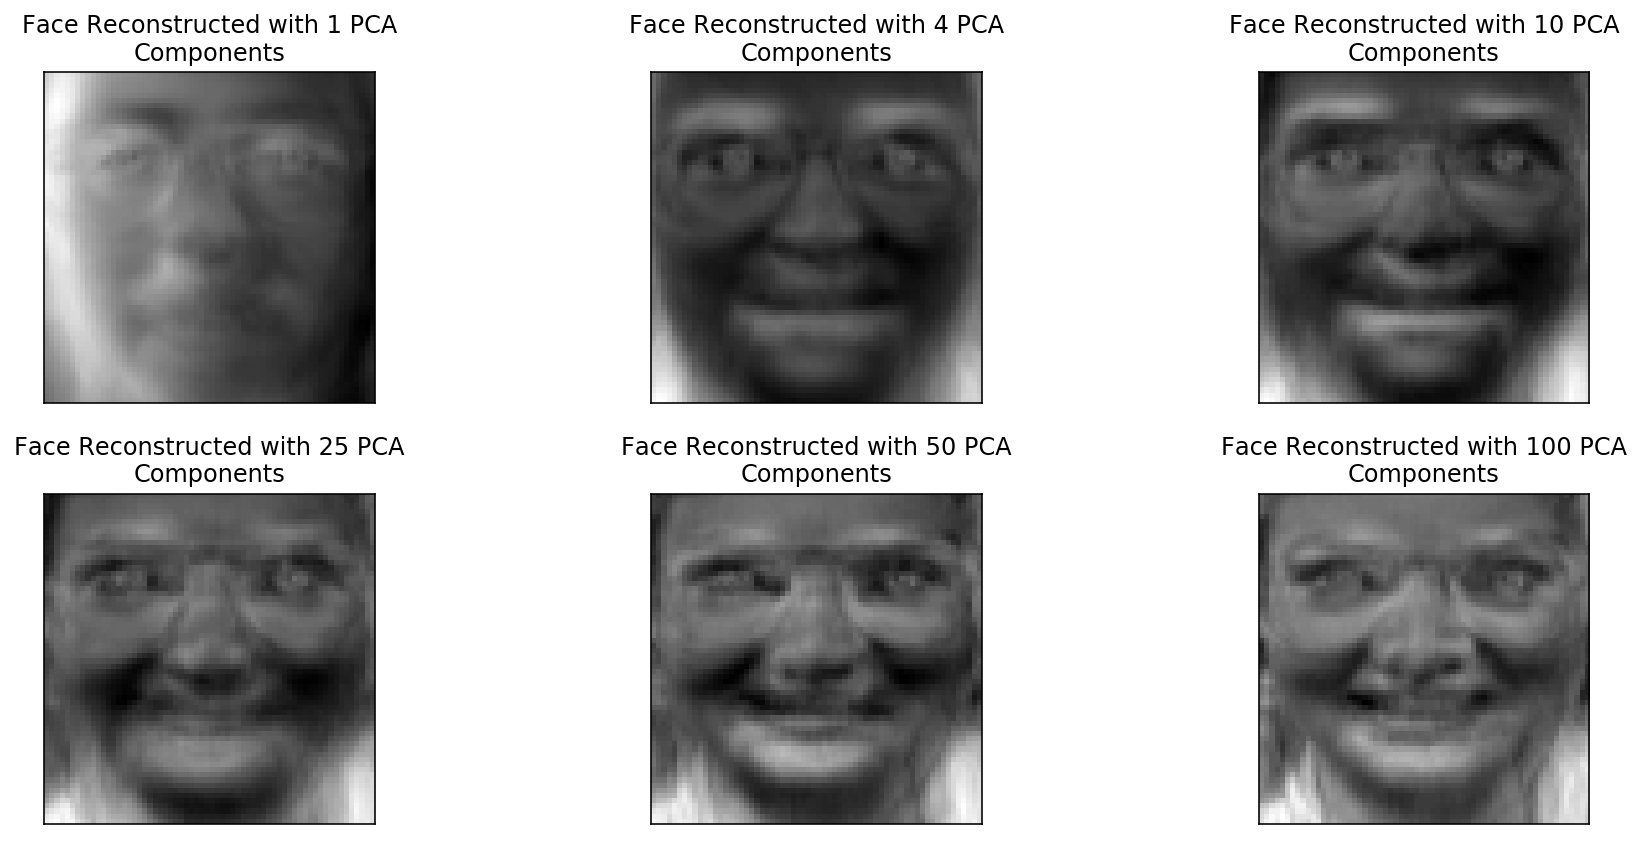

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1, 4, 10, 25, 50, 100]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap="gray")
    ax.set_title("Face Reconstructed with {} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

We were shooting for this:

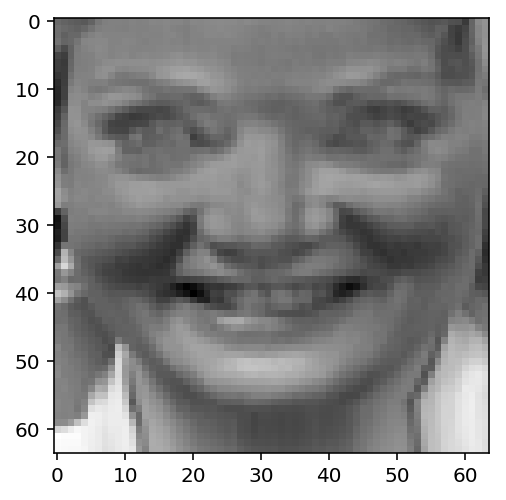

In [41]:
plt.imshow( faces_centered[0].reshape(64,64), cmap="gray" )

### What Principal Component Analysis is NOT For

There is an unfortunately popular method which combines PCA with regression, with the intent of improving the generalization properties of the regression.  It is called **Principal Component Regression** and it goes like this:

**Setup**: You have a matrix $X$ and a response $y$, and you want to fit a regression to predict $y$ from $X$.

**Procedure**:
1. Do PCA on $X$, let $E$ be the matrix of principal components.
2. Discard some of the principal components, get the matrix $E_{k\times p}$.
3. Regress $y$ on $E_{k\times p}$.

**Discussion:** Critique this procedure, pros and cons.

For details on why **not** to use selection of principal components as a regularization strategy in regression [see this paper](http://www.uvm.edu/~rsingle/stat380/F04/possible/Hadi%2BLing-AmStat-1998_PCRegression.pdf) and [this paper](http://automatica.dei.unipd.it/public/Schenato/PSC/2010_2011/gruppo4-Building_termo_identification/IdentificazioneTermodinamica20072008/Biblio/Articoli/PCR%20vecchio%2082.pdf).

See also [this example](https://gist.github.com/lemonlaug/976543b650e53db24ab2) from our own Isaac Laughlin

[This question](http://stats.stackexchange.com/questions/101485/examples-of-pca-where-pcs-with-low-variance-are-useful) gives real life examples of data sets where PCR fails because $y$ is only related to the **low variance** principal components.

Still, PCR gets used (abused?) and comes up in interview questions: http://stats.stackexchange.com/questions/239518/logistic-regression-with-lasso-versus-pca